# LSTM model
**Model2.0** tuning without temperature
### features
wind, swrad, lwrad for each of the select_stations
day of the week
hour of the day
month of the year

### prediction frame
with n = 6 and m = 4
features:
t-n to t+m-1 of climate and time
labels:
t to t+m-1 of load ERCOT

In [1]:
import sys
 
# setting path
sys.path.append('../../data')
from data import *

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,  Flatten

import matplotlib.pyplot as plt

from statistics import mean, stdev
import pandas as pd
import numpy as np
import datetime

In [3]:
start = datetime.datetime.now()

In [4]:
past_hours = 6
n_steps = past_hours
next_hours = 4
next_steps = next_hours

In [5]:
transformations = [e for n in select_stations for e in ('swrad'+str(n), 'lwrad'+str(n), 'wind'+str(n))]
transformations = [(str(i), MinMaxScaler(copy=True), make_column_selector(pattern = e)) for i,e in enumerate(transformations)]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'hour'))]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'day'))]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'month'))]
transformations += [("y",StandardScaler(copy=True), make_column_selector(pattern = 'ERCOT'))]
ct = ColumnTransformer(transformations)

normed_data = pd.DataFrame(ct.fit_transform(load_data))
normed_data

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.0,0.229848,0.175246,0.0,0.236395,0.288098,0.0,0.196951,0.158924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.861036
1,0.0,0.229824,0.200738,0.0,0.236392,0.257994,0.0,0.196983,0.167568,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.727637
2,0.0,0.194472,0.226748,0.0,0.195790,0.229942,0.0,0.158500,0.176048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.782265
3,0.0,0.194472,0.217296,0.0,0.195790,0.191008,0.0,0.158507,0.185629,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.941622
4,0.0,0.194454,0.213117,0.0,0.195790,0.155684,0.0,0.158539,0.195340,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.188049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94909,0.0,0.543971,0.151403,0.0,0.528028,0.254790,0.0,0.568888,0.282454,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436792
94910,0.0,0.520742,0.164654,0.0,0.607941,0.214727,0.0,0.601077,0.251925,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269458
94911,0.0,0.520742,0.242358,0.0,0.607941,0.168782,0.0,0.601074,0.197461,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129600
94912,0.0,0.520742,0.327699,0.0,0.607941,0.123072,0.0,0.601074,0.144117,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005014


In [6]:
dataset = normed_data.values
steps = n_steps+next_steps
time_series =  np.array([dataset[i:i + steps].copy() for i in range(len(dataset) - steps) if load_data.index[i+steps] - load_data.index[i] == datetime.timedelta(hours=steps)])

time_series.shape

(94378, 10, 68)

In [7]:
X = time_series[:, :n_steps, :]
Y = time_series[:, n_steps:, -1]

print(X.shape, Y.shape)

(94378, 6, 68) (94378, 4)


In [8]:
#sizes for test, train, and validation datasets
a = len(time_series)
b = int(0.9*a)
c = int(a-b)//2

In [9]:
X_train,    Y_train =   X[:b],      Y[:b]
X_val,      Y_val   =   X[b:b+c],   Y[b:b+c]
X_test,     Y_test  =   X[b+c:],    Y[b+c:]

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(84940, 6, 68) (4719, 6, 68) (4719, 6, 68)
(84940, 4) (4719, 4) (4719, 4)


In [10]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Flatten(),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="relu"),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(next_steps)
])

In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 256)            332800    
                                                                 
 lstm_1 (LSTM)               (None, 6, 256)            525312    
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [12]:
EPOCHS = 30

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1)

Epoch 1/30
2655/2655 [==============================] - 149s 53ms/step - loss: 0.1019 - mae: 0.2344 - mse: 0.1019 - val_loss: 0.1019 - val_mae: 0.2349 - val_mse: 0.1019
Epoch 2/30
2655/2655 [==============================] - 140s 53ms/step - loss: 0.0376 - mae: 0.1478 - mse: 0.0376 - val_loss: 0.0519 - val_mae: 0.1647 - val_mse: 0.0519
Epoch 3/30
2655/2655 [==============================] - 144s 54ms/step - loss: 0.0283 - mae: 0.1276 - mse: 0.0283 - val_loss: 0.0324 - val_mae: 0.1315 - val_mse: 0.0324
Epoch 4/30
2655/2655 [==============================] - 143s 54ms/step - loss: 0.0235 - mae: 0.1157 - mse: 0.0235 - val_loss: 0.0243 - val_mae: 0.1114 - val_mse: 0.0243
Epoch 5/30
2655/2655 [==============================] - 142s 53ms/step - loss: 0.0207 - mae: 0.1084 - mse: 0.0207 - val_loss: 0.0266 - val_mae: 0.1214 - val_mse: 0.0266
Epoch 6/30
2655/2655 [==============================] - 144s 54ms/step - loss: 0.0184 - mae: 0.1021 - mse: 0.0184 - val_loss: 0.0272 - val_mae: 0.1235 - va

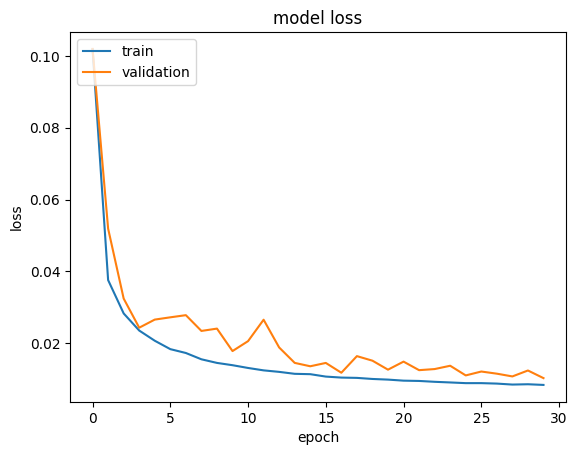

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
test_predictions = model.predict(X_test)
op_list= [e for y in test_predictions for e in y]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list
print(len(op_list), len(ip_list))

148/148 [==============================] - 3s 16ms/step
18876 18876


In [24]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -0.29847861537136994
Mean of absolute error in test data: 657.7010777740252
Root of mean of squared error in test data: 920.6308412357357
Standard deviation of error in test data: 920.65518009838
MPE (%): 0.10001356056500214
MAPE (%): 1.343170121404086
RMSPE (%): 1.8051169178681534
Deviation of error (%): 1.8023918768930831
Mean of test data: 47586.94378734902
Standard deviation of test data: 10122.94285891266
Coefficient of determination: 0.9917285723178192


In [16]:
#absolute errors
for threshold in [5,10,50,100,500,1000,1500,2000,3000,4000,5000]:
    accuracy = sum(abs(e) < threshold for e in error)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 0.6940029667302394 % with threshold of 5
accuracy: 1.313837677474041 % with threshold of 10
accuracy: 5.853994490358127 % with threshold of 50
accuracy: 11.866920957830049 % with threshold of 100
accuracy: 52.52172070353889 % with threshold of 500
accuracy: 78.94681076499258 % with threshold of 1000
accuracy: 90.76605212968849 % with threshold of 1500
accuracy: 95.47043865225685 % with threshold of 2000
accuracy: 98.91396482305574 % with threshold of 3000
accuracy: 99.74570883661794 % with threshold of 4000
accuracy: 99.90993854630219 % with threshold of 5000


In [17]:
#relative errors
for threshold in [0.5,1,1.5,2,3,4,5]:
    accuracy = sum(abs(e) < threshold for e in rerror)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 26.01716465352829 % with threshold of 0.5
accuracy: 48.96164441618987 % with threshold of 1
accuracy: 66.07332061877517 % with threshold of 1.5
accuracy: 78.17334180970545 % with threshold of 2
accuracy: 90.8826022462386 % with threshold of 3
accuracy: 96.31807586353041 % with threshold of 4
accuracy: 98.24115278660733 % with threshold of 5


In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 48})

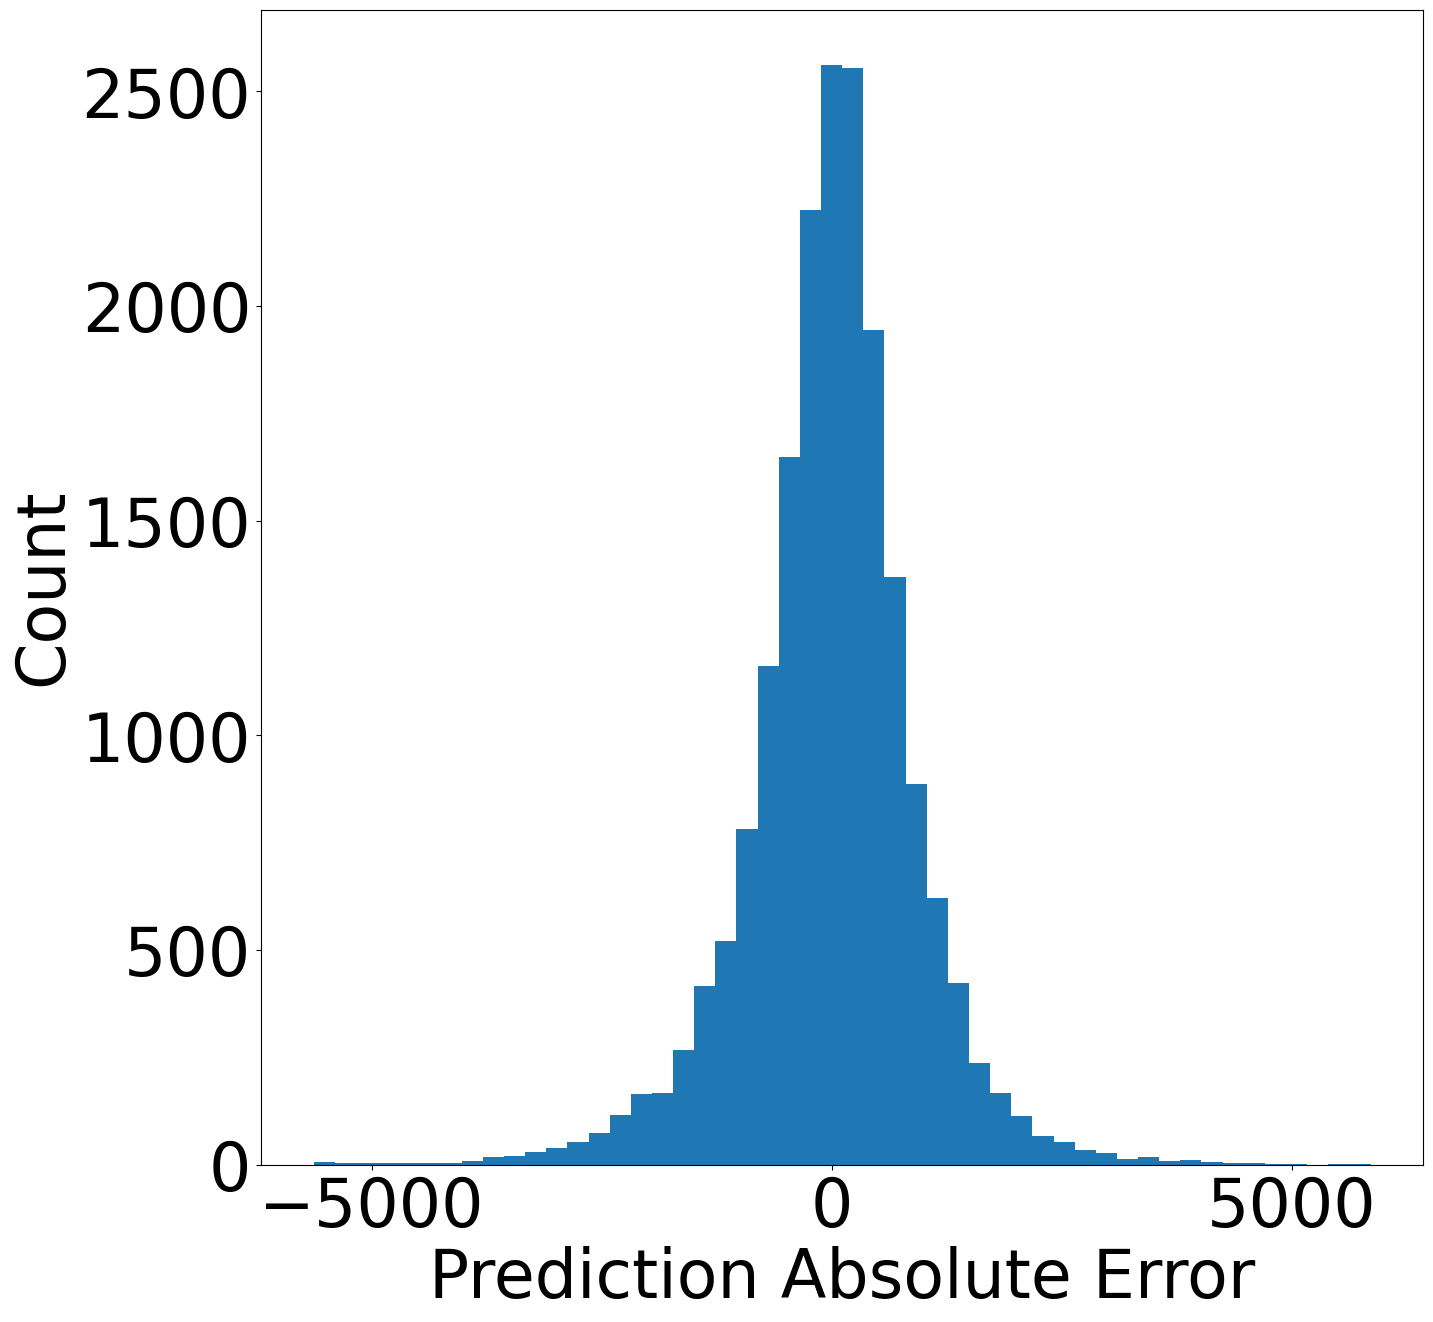

In [19]:
plt.figure(figsize=(15,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Absolute Error")
_ = plt.ylabel("Count")

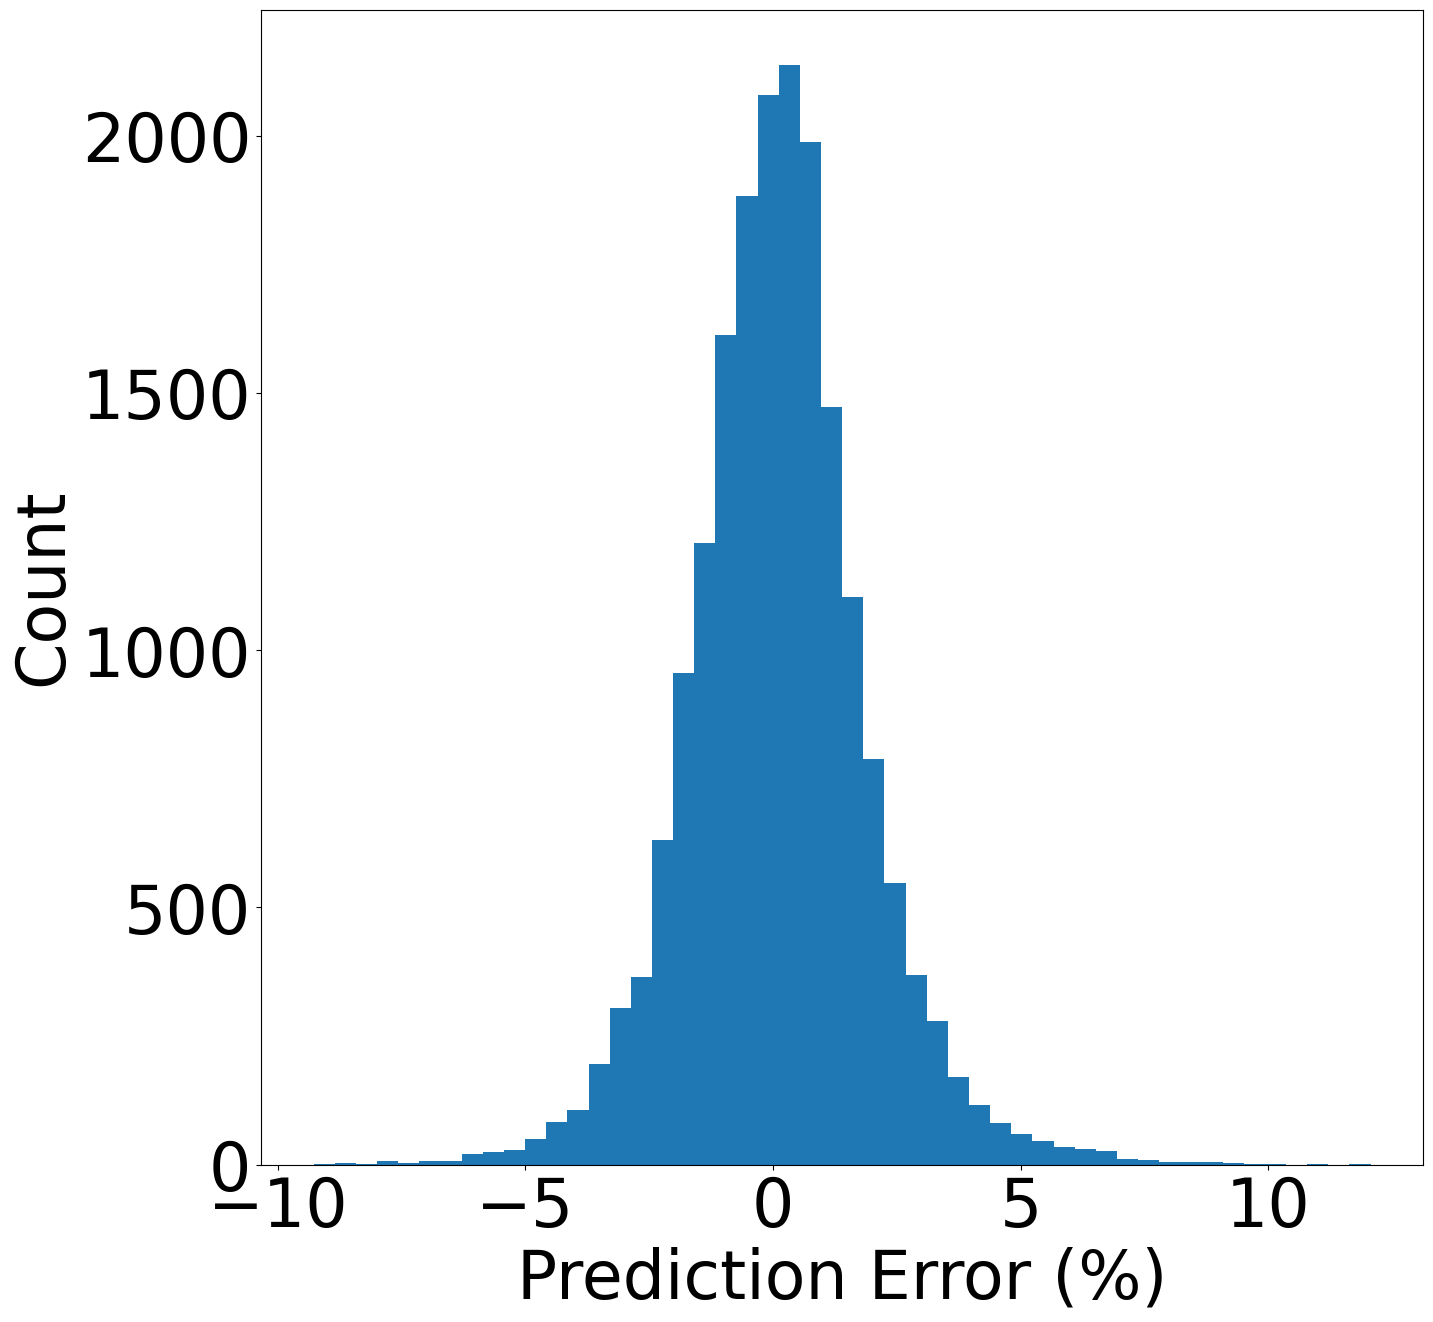

In [20]:
plt.figure(figsize=(15,15))
plt.hist(rerror, bins = 50)
plt.xlabel("Prediction Error (%)")
_ = plt.ylabel("Count")

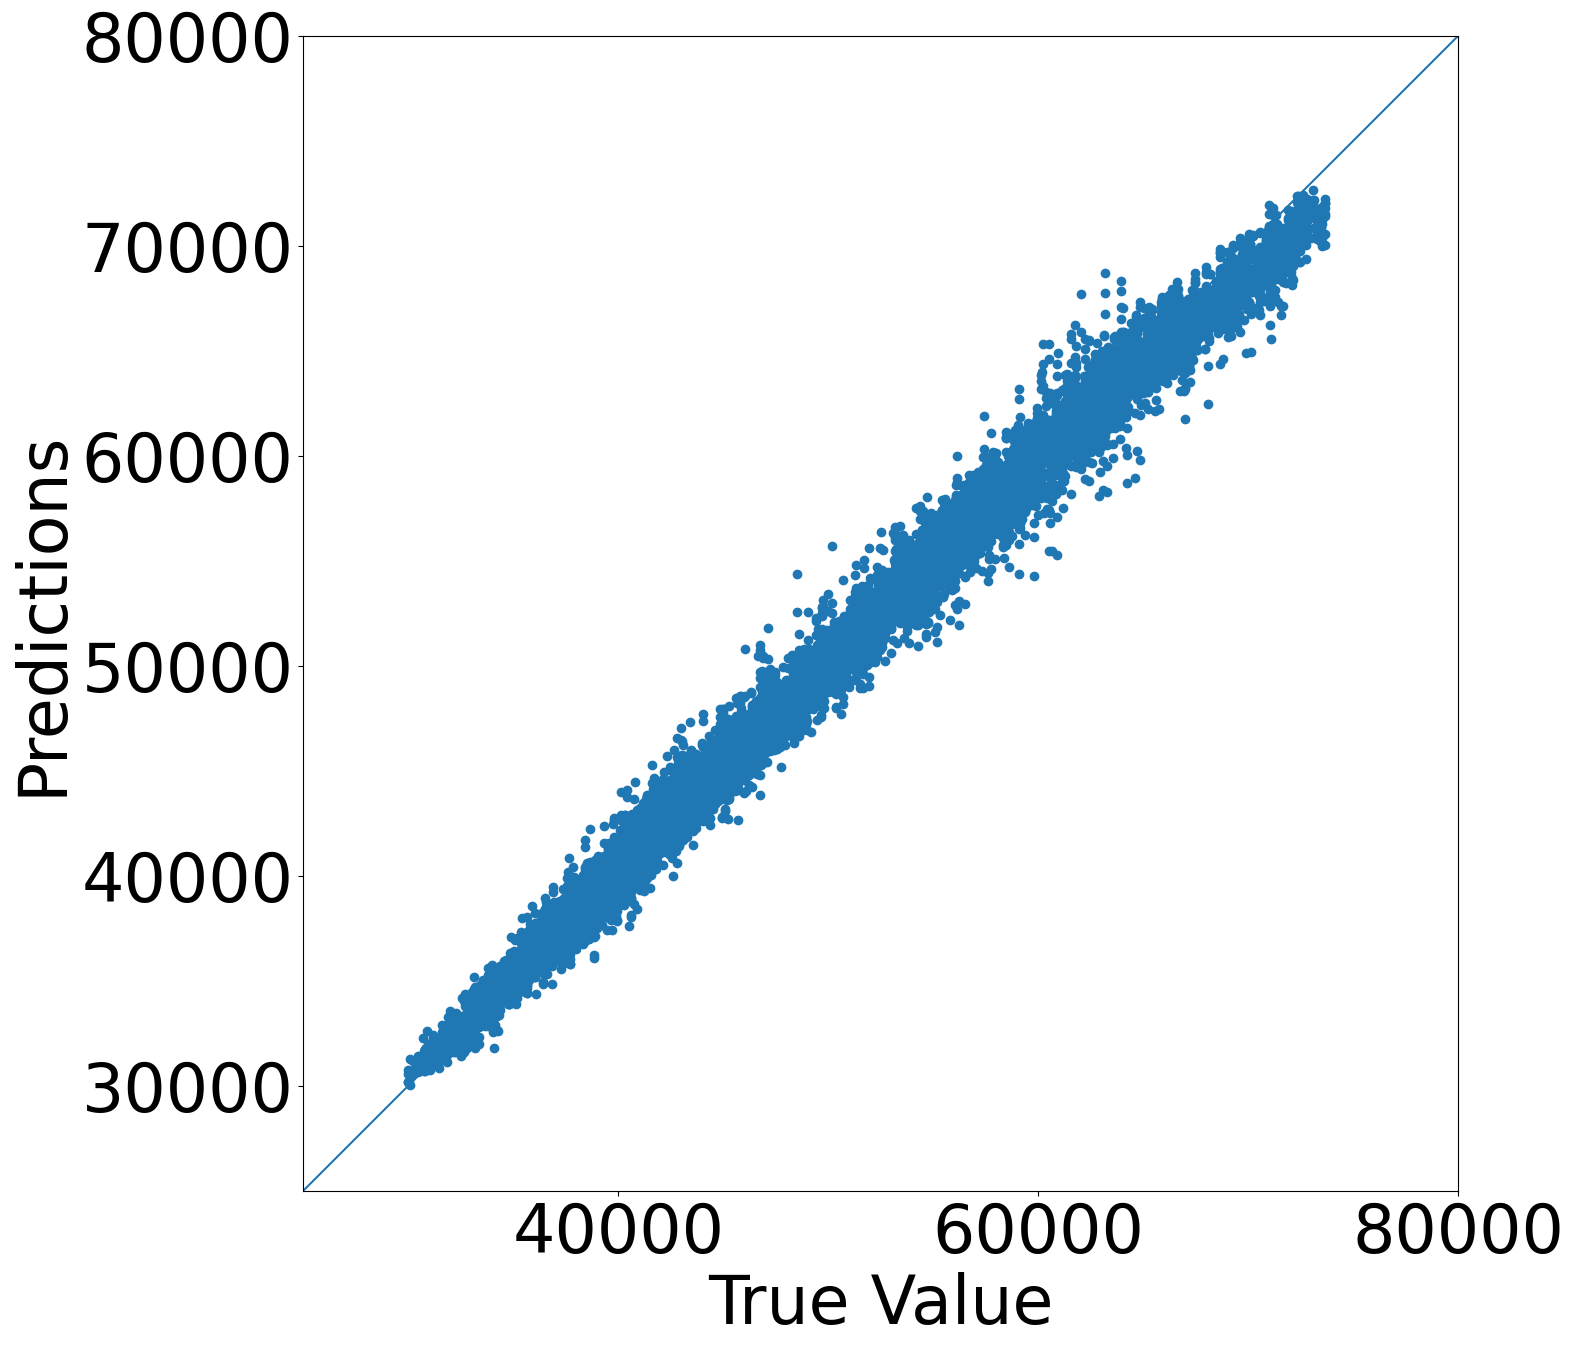

In [21]:
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual'], predictions)
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [25000, 80000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [22]:
end = datetime.datetime.now()
print('total time:', end-start)

total time: 1:14:59.171644


In [23]:
from keras.models import save_model
save_model(model,'Models/LSTM_model_3.0.1.h5',include_optimizer=True)
np.save('Models/LSTM_history_3.0.1.npy',history.history)